In [6]:
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)

color_pal =plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key='3c2907cedd45816a19f75689e2e59cc3'

## Create Fred Object

In [7]:
fred = Fred(api_key=fred_key)

In [8]:
sp_search = fred.search('S&P', order_by='popularity')
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2023-12-14   2023-12-14   
CSUSHPINSA          CSUSHPINSA     2023-12-14   2023-12-14   
SP500                    SP500     2023-12-14   2023-12-14   
MEHOINUSA672N    MEHOINUSA672N     2023-12-14   2023-12-14   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2023-12-14   2023-12-14   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA        S&P/Case-Shiller U.S. National Home Price Index   
SP500                                                     S&P 500   
MEHOINUSA672N   Real Median Household Income in the United States   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2023-12-13  Daily, Close   
CSUSHPINSA            1987-01-01      2023-09-01       Monthly   
SP500                 2013-12-16      2023-12-13  Daily, Close   
MEHOINUSA672N         1984-01-01      2022-01-01        Annual   
BAMLH0A0HYM2EY        1996-12-31      2023-12-13  Daily, Close   

               frequency_short                           units  \
series id                                                        
BAMLH0A0HYM2                 D                         Percent   
CSUSHPINSA                   M              Index Jan 2000=100   
SP500                        D                           Index   
MEHOINUSA672N                A  2022 CPI-U-RS Adjusted Dollars   
BAMLH0A0HYM2EY               D                         Percent   

                             units_short      seasonal_adjustment  \
series id                                                           
BAMLH0A0HYM2                           %  Not Seasonally Adjusted   
CSUSHPINSA            Index Jan 2000=100  Not Seasonally Adjusted   
SP500                              Index  Not Seasonally Adjusted   
MEHOINUSA672N   2022 CPI-U-RS Adjusted $  Not Seasonally Adjusted   
BAMLH0A0HYM2EY                         %  Not Seasonally Adjusted   

               seasonal_adjustment_short               last_updated  \
series id                                                             
BAMLH0A0HYM2                         NSA  2023-12-14 09:08:02-06:00   
CSUSHPINSA                           NSA  2023-11-28 08:12:02-06:00   
SP500                                NSA  2023-12-13 19:11:02-06:00   
MEHOINUSA672N                        NSA  2023-09-12 13:48:02-05:00   
BAMLH0A0HYM2EY                       NSA  2023-12-14 09:08:05-06:00   

               popularity                                              notes  
series id                                                                     
BAMLH0A0HYM2           93  The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA             88  For more information regarding the index, plea...  
SP500                  84  The observations for the S&P 500 represent the...  
MEHOINUSA672N          83  Household data are collected as of March.  As ...  
BAMLH0A0HYM2EY         83  This data represents the effective yield of th...

## Pull Raw Data & Plot

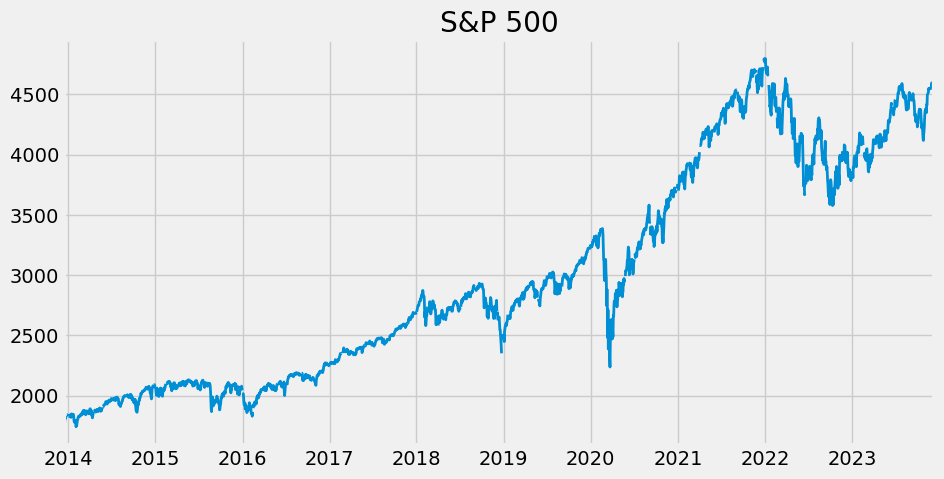

In [9]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

## Pull and Join Multiple Data Series

In [10]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [12]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
uemp_results = pd.concat(all_results, axis=1)

In [13]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [14]:
uemp_states = uemp_results.copy() 
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [15]:
px.line(uemp_states)

## Pull April 2020 Unemployment Rate Per State

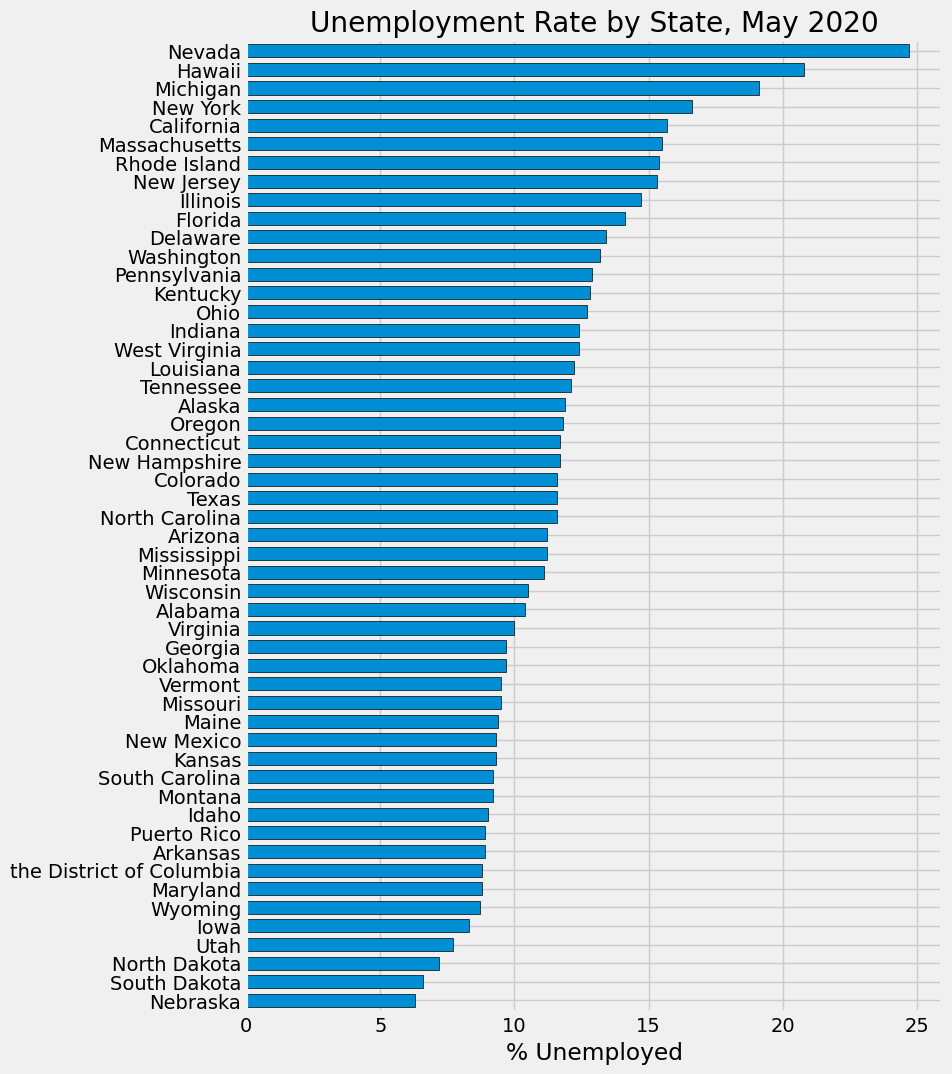

In [16]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

## Pull Participation Rate

In [17]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [19]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

## Plot Unemployment vs Participation for each state

In [20]:
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

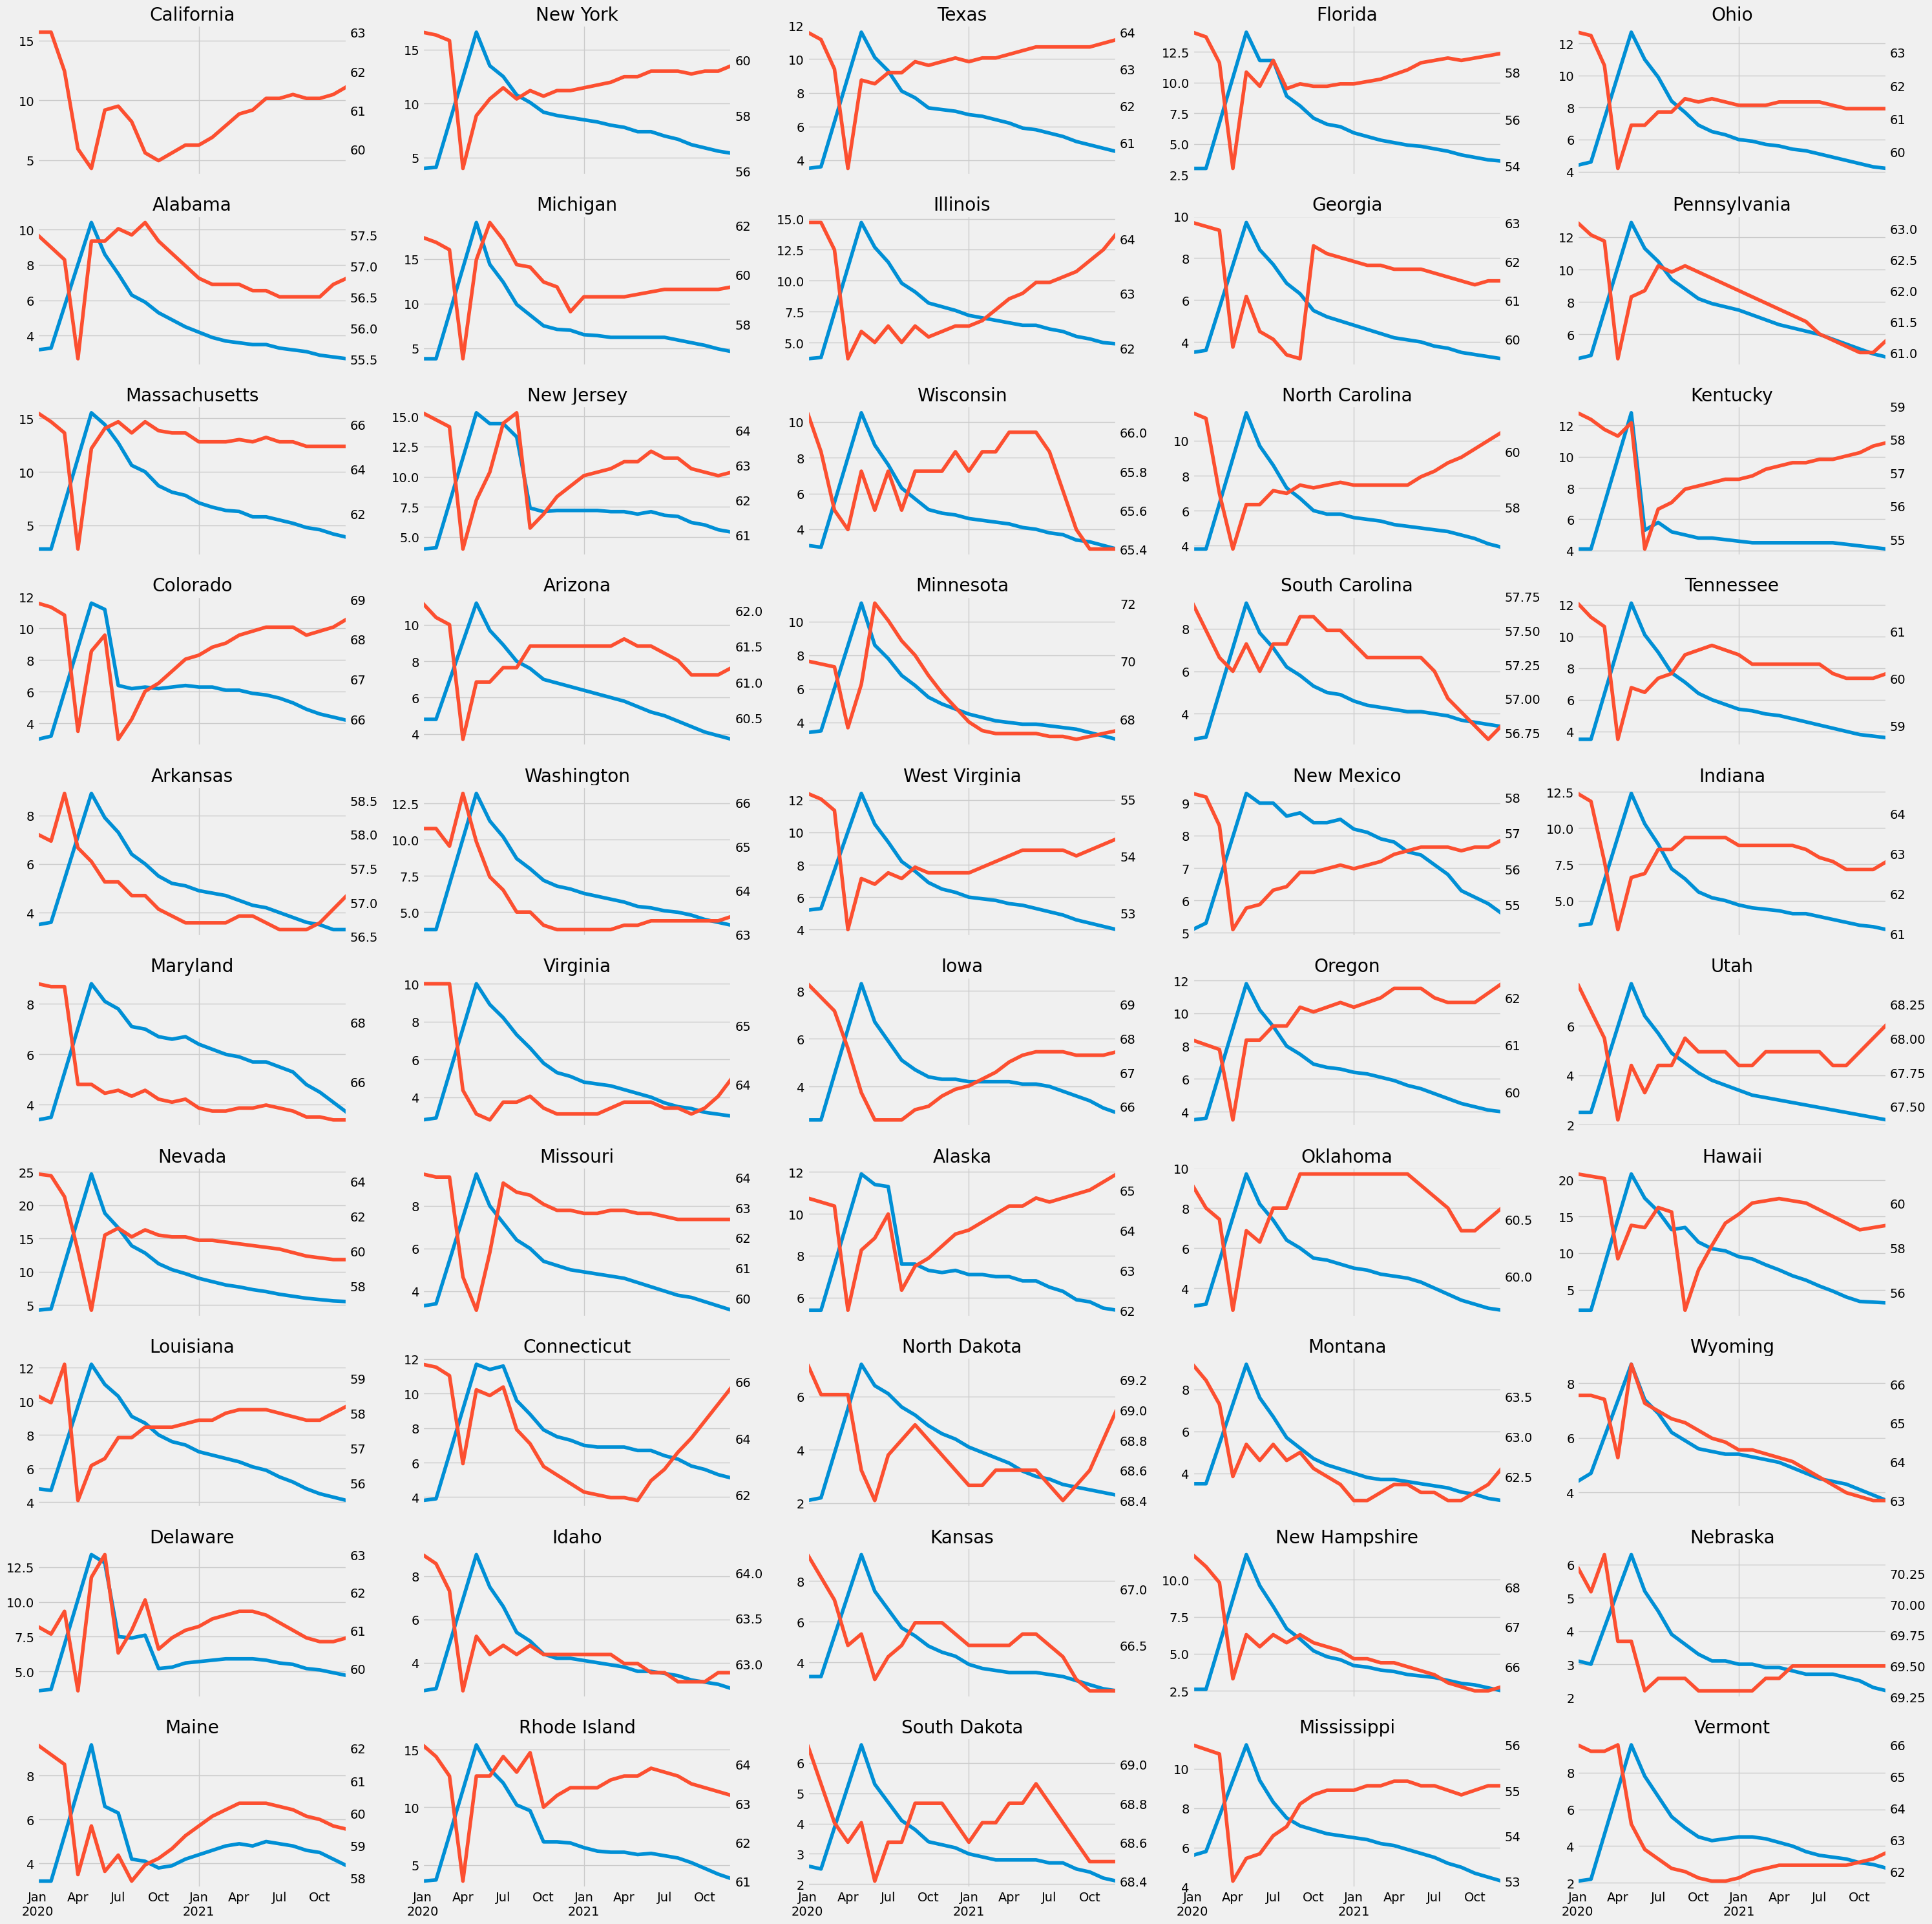

In [21]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

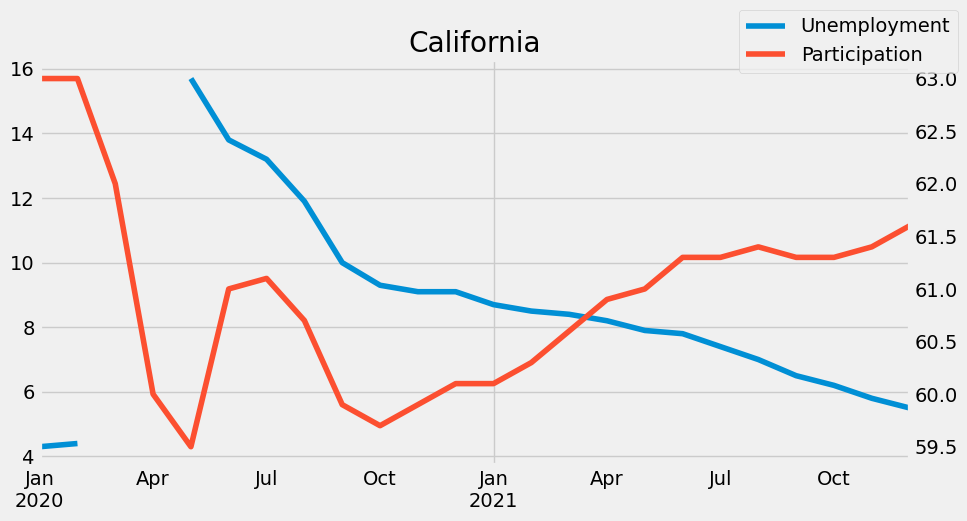

In [22]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()